In [1]:
from dg_ml_core.collections import dict_ops
from dg_ml_core import file
from dg_ml_core.datastores import gcs_utils
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=ResourceWarning)
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

# Generate Table of dataset stats

In [18]:
def get_mean_std_string(key, dataset_stats):
    return str(np.round(dataset_stats['mean_' + key], 2)) + ' $\\pm$ ' + str(np.round(dataset_stats['std_' + key], 2))

def get_grouped_number(number):
    if len(number) > 3:
        return f'{int(number):,}'.replace(",", "'")
#         grouped_number = ''
#         for digit, idx in enumerate(number[::-1]):
#             if int(idx) % 3 == 0 and int(idx) > 0:
#                 grouped_number += "'"
#             grouped_number += str(digit)
#         return grouped_number[::-1]
    else:
        return number

dataset_names = ['micro', 'midi', 'maxi']
stats_strings = dict()
for dataset in dataset_names:
    stats_path = f"gs://ma-muy/03_datasets/{dataset}_dataset/03_dataset_stats.json"
    dataset_stats = dict_ops.load_dict(stats_path)
    stats_strings[dataset] = []
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_users'])))
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_products'])))
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_events'])))
    stats_strings[dataset].append(get_grouped_number(str(dataset_stats['num_sessions'])))
    stats_strings[dataset].append(get_mean_std_string('sessions_per_user', dataset_stats))
    stats_strings[dataset].append(get_mean_std_string('events_per_product', dataset_stats))
    stats_strings[dataset].append(get_mean_std_string('events_per_session', dataset_stats))

headers = ['Property', 'MINI Dataset', 'MIDI Dataset', 'MAXI Dataset']
property_names = ['\\#Users', '\\#Products', '\\#Events', '\\#Sessions', '\\#Sessions per User', '\\#Events per Product', '\\#Events per Session']
print(' & '.join(headers) + ' \\\\ \\hline')
for a, b, c, d in zip(property_names, stats_strings['micro'], stats_strings['midi'], stats_strings['maxi']):
    print(f"{a} & {b} & {c} & {d} \\\\ \\hline")

Property & MINI Dataset & MIDI Dataset & MAXI Dataset \\ \hline
\#Users & 23 & 15'242 & 242'797 \\ \hline
\#Products & 161 & 42'103 & 470'817 \\ \hline
\#Events & 633 & 1'234'697 & 28'726'701 \\ \hline
\#Sessions & 183 & 250'187 & 4'652'496 \\ \hline
\#Sessions per User & 7.96 $\pm$ 5.41 & 16.41 $\pm$ 22.08 & 19.16 $\pm$ 28.67 \\ \hline
\#Events per Product & 3.93 $\pm$ 5.84 & 29.33 $\pm$ 69.98 & 61.27 $\pm$ 263.3 \\ \hline
\#Events per Session & 3.46 $\pm$ 0.82 & 4.94 $\pm$ 3.07 & 6.17 $\pm$ 60.22 \\ \hline


# Generate Histogram of Visits per Product/User

In [136]:
def generate_histogram(events, filename):
    ax = sns.distplot(events, kde=False, hist_kws={'log':True})
    ax.get_figure().savefig(filename, dpi=200)

## Generate events_per_user.json

In [147]:
data_prefix = 'gs://ma-muy/03_datasets/maxi_dataset/01_complete'
file_paths = file.get_paths_with_prefix(data_prefix)
gcs_client = gcs_utils.get_client('machinelearning-prod', None)

events_per_user = dict()

for file_path in file_paths:
    print('=', end='')
    sessions_by_user = dict_ops.load_dict(file_path, gcs_client=gcs_client)
    for user in sessions_by_user:
        num_events = 0
        for session in sessions_by_user[user]:
            num_events += len(sessions_by_user[user][session]['Events'])
        if num_events < 20000:
            events_per_user[user] = num_events
        
dict_ops.save_dict('gs://ma-muy/03_datasets/maxi_dataset/08_events_per_user.json', events_per_user)

## Download relevant files

In [148]:
file_path = 'gs://ma-muy/03_datasets/maxi_dataset/02_events_per_product.json'
file.copy_file(file_path, 'events_per_product.json')
file_path = 'gs://ma-muy/03_datasets/maxi_dataset/08_events_per_user.json'
file.copy_file(file_path, 'events_per_user.json')

## Generate Histograms

Number of products: 470817


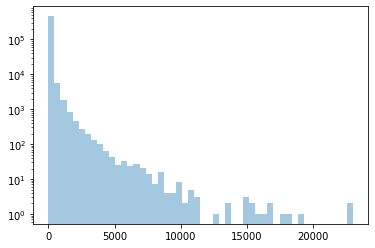

In [149]:
events_per_product = dict_ops.load_dict('events_per_product.json')
events = list(events_per_product.values())
print("Number of products:", len(events))
generate_histogram(events, "histo_product_visits.png")

Number of users: 242794


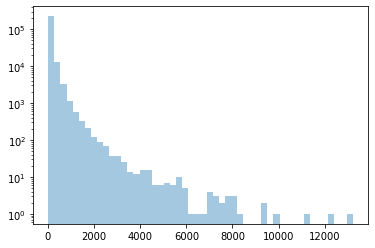

In [150]:
events_per_user = dict_ops.load_dict('events_per_user.json')
events = list(events_per_user.values())
print("Number of users:", len(events))
generate_histogram(events, "histo_user_visits.png")

# Generate PCA of user/product embeddings

## Download relevant files

In [30]:
product_embeddings_path = 'gs://ma-muy/product_embeddings.json'
file.copy_file(product_embeddings_path, 'product_embeddings.json')
print(len(dict_ops.load_dict('product_embeddings.json')).keys())
user_embeddings_path = 'gs://ma-muy/04_model_artifacts/with_user_one_hot/1/user_embeddings.json'
file.copy_file(user_embeddings_path, 'user_embeddings.json')
print(len(dict_ops.load_dict('user_embeddings.json')).keys())

3269826
242797


## Filter product embeddings

In [6]:
relevant_product_ids = set(dict_ops.load_dict('gs://ma-muy/03_datasets/maxi_dataset/02_events_per_product.json').keys())
product_embeddings = dict_ops.load_dict('product_embeddings.json')
product_ids = list(product_embeddings.keys())
for product_id in product_ids:
    if product_id not in relevant_product_ids:
        _ = product_embeddings.pop(product_id, None)
dict_ops.save_dict('relevant_product_embeddings.json', product_embeddings)

## Generate PCAs

In [162]:
def compute_pca(freq_dict, embedding_dict):
    events_per_item = dict_ops.load_dict(freq_dict)
    embeddings = dict_ops.load_dict(embedding_dict)
    data = []
    embedding_size = 0
    for item_id in embeddings:
        if item_id in events_per_item:
            row = embeddings[item_id]
            embedding_size = len(row)
            if events_per_item[item_id] > 10000:
                row.append('>10k')
            elif events_per_item[item_id] > 1000:
                row.append('>1k')
            elif events_per_item[item_id] > 100:
                row.append('>100')
            else:
                row.append('<100')
            data.append(row)
    df = pd.DataFrame(data)
    df = df.rename({embedding_size: "#Events"}, axis=1).groupby(by='#Events', as_index=False).apply(lambda x: x if len(x) < 1000 else x.sample(1000))
    features = [x for x in range(embedding_size)]
#     print("Features:", features)
    target = '#Events'
    x = df.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    pca = KernelPCA(n_components=2, kernel='linear')
#     pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    result_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
#     return result_df, 
    result_df = pd.concat([result_df, df.reset_index()[[target]]], axis=1, ignore_index=True)

    return result_df

def visualize_pca(df):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    # TODO: Targets extracted from df
    targets = df[2].unique()
#     targets = ['>10k', '>1k', '>100', '<100']
    colors = ['r', 'g', 'b', 'y'][:len(targets)]
    for target, color in zip(targets, colors):
        indicesToKeep = df[2] == target
        ax.scatter(df.loc[indicesToKeep, 0], df.loc[indicesToKeep, 1], c = color, s = 50)
    ax.legend(targets)
    ax.grid()

<100    1000
>100    1000
>1k     1000
>10k      29
Name: 2, dtype: int64
<100    0.283
>100    0.504
>1k     0.850
>10k    1.000
Name: 2, dtype: float64


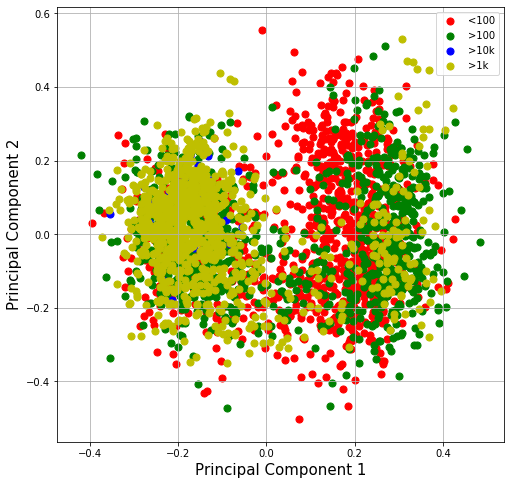

In [156]:
df = compute_pca('events_per_product.json', 'relevant_product_embeddings.json')
print(df[2].value_counts())
negative_indices = df[0] < 0.0
print((df[negative_indices][2].value_counts() / df[2].value_counts()).sort_values())
visualize_pca(df)

<100    1000
>100    1000
>1k     1000
>10k       3
Name: 2, dtype: int64
>10k    0.666667
>1k     0.719000
<100    0.751000
>100    0.758000
Name: 2, dtype: float64


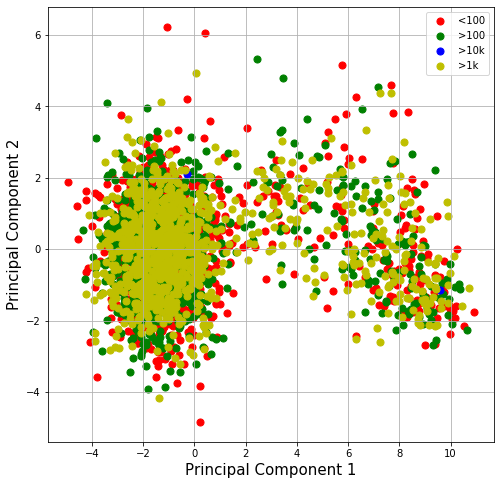

In [163]:
df = compute_pca('events_per_user.json', 'user_embeddings.json')
print(df[2].value_counts())
negative_indices = df[0] < 0.0
print((df[negative_indices][2].value_counts() / df[2].value_counts()).sort_values())
visualize_pca(df)